This notebook calculates temporal amplitude dispersion for each pixel and saves it so it can be used for a mask to display "stable"/good pixels vs. bad ones. Also looks at average amplitude (bright pixels usually more stable)


This notebook: <br>
1. loads in cropped section of the SLCs 
2. pulls out the amplitude ...
3. ...

This notebook was written 6-13-23.

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime  
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

In [2]:
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates)

Read in the SLCs. Put them all into an array.

In [3]:
# shape of my cropped area
# larger box with western mtns
x1 = 18000
y1 = 2100
x2 = 14000
y2 = 1000
dx = x1-x2
dy = y1-y2
# make an array to hold igrams
SLC_amps = np.ndarray((nd,dy,dx),dtype='float')
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
# load in all SLCs 
for i in range(nd):
    # Read in the section of the SLC  
    ds = gdal.Open(datesDir+'SLC_vv/'+dates[i]+'/'+dates[i]+'.slc.full', gdal.GA_ReadOnly)
    temp_SLC = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx,dy)
    SLC_amps[i] = np.abs(temp_SLC)
print('SLCs loaded.')

KeyboardInterrupt: 

Plot one SLC amp to see if I loaded them correctly. 

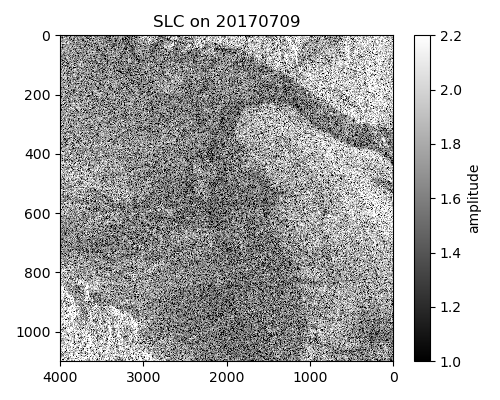

In [ ]:
k = 5
low = 1
high = 2.2
plt.figure(figsize=(5,4),tight_layout=True)
plt.imshow(np.log10(SLC_amps[k]),aspect='auto',interpolation='nearest',vmin=low,vmax=high)
plt.set_cmap('gray'); plt.colorbar(label='amplitude')
plt.xlim([dx,0]); plt.ylim([dy,0]); 
plt.title('SLC on '+dates[k])
plt.show()

Calculate amplitude dispersion for each pixel (temporal) and the pixel's average amplitude over time. <br>
Takes ~5 minutes to run. 

In [ ]:
amp_dispersion = np.ndarray((dy,dx),dtype='float')
avg_amp = np.ndarray((dy,dx),dtype='float')
med_amp = np.ndarray((dy,dx),dtype='float')

for y in range(dy):
    for x in range(dx):
        temp_amps = SLC_amps[:,y,x]
        amp_dispersion[y,x] = np.std(temp_amps)/np.mean(temp_amps)
        avg_amp[y,x] = np.mean(temp_amps,axis=0)
        med_amp[y,x] = np.median(temp_amps,axis=0)
print('done calculating amp dispersion, avg amp, and median amp for each pixel')       

done calculating amp dispersion, avg amp, and median amp for each pixel


Plot them.

In [ ]:
print(np.mean(amp_dispersion))
print(np.mean(avg_amp))
print(np.mean(med_amp))

0.49131044083404896
58.892989881851165
56.30761708296386


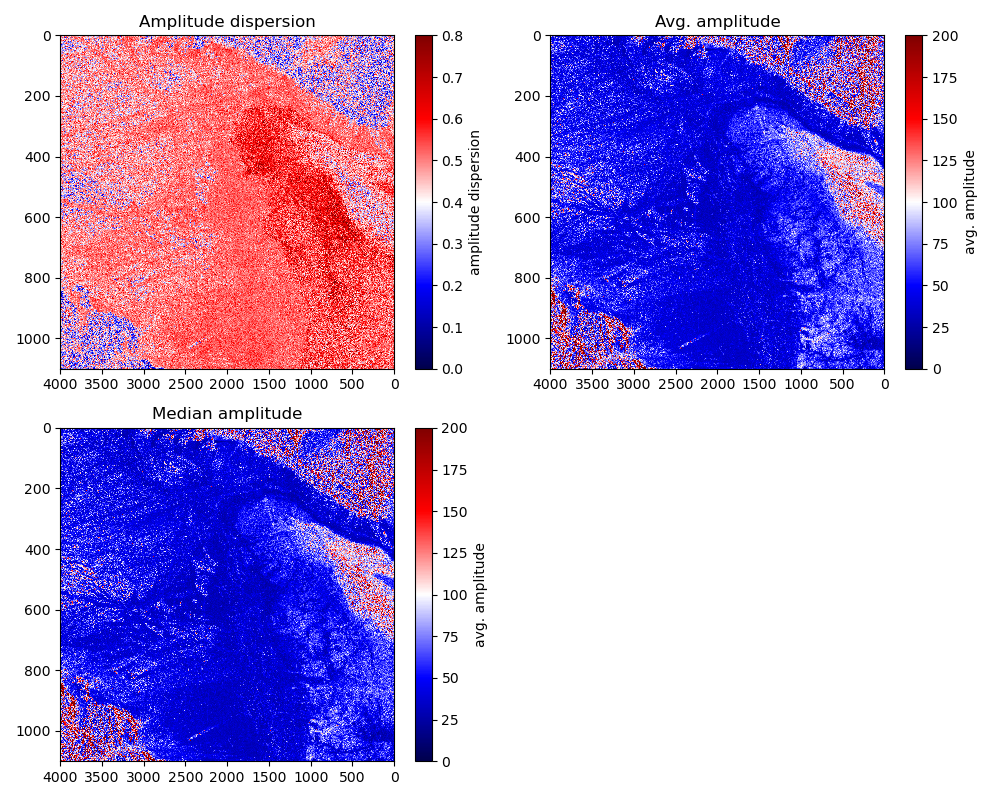

In [ ]:
plt.figure(figsize=(10,8),tight_layout=True)
plt.subplot(2,2,1)
plt.imshow(amp_dispersion,aspect='auto',interpolation='nearest',vmin=0,vmax=0.8)
plt.set_cmap('seismic'); plt.colorbar(label='amplitude dispersion')
plt.xlim([dx,0]); plt.ylim([dy,0]); 
plt.title('Amplitude dispersion')
plt.subplot(2,2,2)
plt.imshow(avg_amp,aspect='auto',interpolation='nearest',vmin=0,vmax=200)
plt.set_cmap('seismic'); plt.colorbar(label='avg. amplitude')
plt.xlim([dx,0]); plt.ylim([dy,0]); 
plt.title('Avg. amplitude')
plt.subplot(2,2,3)
plt.imshow(med_amp,aspect='auto',interpolation='nearest',vmin=0,vmax=200)
plt.set_cmap('seismic'); plt.colorbar(label='avg. amplitude')
plt.xlim([dx,0]); plt.ylim([dy,0]); 
plt.title('Median amplitude')
plt.show()

Save the files. 

In [21]:
fileName = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/amp_dispersion.r4'
colds = driver.Create(fileName,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(amp_dispersion)
colds=None
fileName = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/avg_amp.r4'
colds = driver.Create(fileName,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(avg_amp)
colds=None
print('amp files saved.')

amp files saved.


In [ ]:
fileName = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/med_amp.r4'
colds = driver.Create(fileName,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(med_amp)
colds=None